
作业五：借助文档(custom_optimizer)的代码结构，实现带动量的随机梯度下降算法(SGD with momentum) 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from torch.optim import Optimizer

from sklearn import datasets
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_boston(ratio=0.8):
    X, Y = datasets.load_boston(True)
    Y.shape = -1, 1
    
    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    num_samples = len(Y)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = X[idx[:num_train]], Y[idx[:num_train]]
    validdata = X[idx[num_train:]], Y[idx[num_train:]]
    
    return traindata, validdata

In [4]:
class SGD_momentum(torch.optim.Optimizer):
    def __init__(self, params,vs, lr=1e-3,gamma=0.9):
        # 将参数导回Optimizer，这样可以允许lr_scheduler修改lr
        defaults = dict(vs=vs,lr=lr,gamma=gamma)
        super().__init__(params, defaults)
        
    def step(self):
        
        for group in self.param_groups:
            for p ,v in zip(group['params'],vs):
                if p.grad is None:
                    continue
                grad = p.grad.data
                v[:]= group["gamma"]*v+group['lr']*grad
                
                
                p.data.add_(-v) # in-place add

In [30]:
(X_train, Y_train), (X_valid, Y_valid) = load_boston()
X_train, Y_train = torch.Tensor(X_train).cuda(), torch.Tensor(Y_train).cuda()
X_valid, Y_valid = torch.Tensor(X_valid).cuda(), torch.Tensor(Y_valid).cuda()

In [31]:
model = torch.nn.Sequential(
    torch.nn.Linear(13, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 1)
)

In [32]:
model=model.cuda()

In [33]:
loss = torch.nn.MSELoss()

In [34]:
### 初始化vs
vs = []
for param in model.parameters():
    vs.append(torch.zeros_like(param.data))
# 使用自定义优化器
opt =SGD_momentum(model.parameters(),vs, lr=1e-2,gamma=0.9)
# opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9) # pytorch动量

In [35]:
valid_losses = []
train_losses = []
for i in range(301):
    X, Y = X_train, Y_train
    
    opt.zero_grad()
    l = loss(model(X), Y)
    l.backward()
    opt.step()
    
    with torch.no_grad():
        cur_train_loss = l
        cur_valid_loss = loss(Y_valid, model(X_valid))
        valid_losses.append(cur_valid_loss) 
        train_losses.append(cur_train_loss)

        if i%100 == 0:
            print(f"Iter {i}: loss {cur_train_loss:.4f}, valid loss {cur_valid_loss:.4f}")

Iter 0: loss 2.1330, valid loss 0.9704
Iter 100: loss 0.0293, valid loss 0.0365
Iter 200: loss 0.0288, valid loss 0.0358
Iter 300: loss 0.0283, valid loss 0.0354


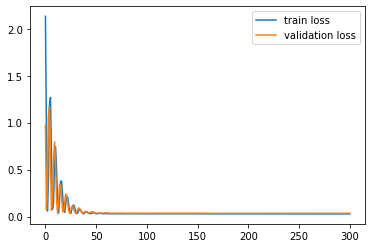

In [36]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])